# Notebook Fine-Tuning Bert
In diesem Notebook wird Bert bzw. 'BertForSequenceClassification' feingetuned. <br>
Funktionen werden aus diesem [Skript](bert_no_ernie.py) geladen.

In [42]:
import pandas as pd
from bert_no_ernie import *


## Rohdaten einlesen
An dieser Stelle, wird der Hackathon Datensatz eingelesen welcher Annotierte Daten enthält.
Die wichtigsten Attribute dieses Datensatzes in diesem sind *Text* (welcher den "Witz" als String enthält) und *is_humor* (ein durch 0 und 1 dargestellter Wahrheitswert) welcher angibt ob der entsprechende Text in der Zeile ein Witz ist oder nicht.

In [2]:
df = pd.read_csv("data/hack.csv")
df.head()

id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  humor_controversy  offense_rating  
0          2.42                1.0             0.2  
1          2.50                1.0             1.1  
2          1.95                0.0             2.4  
3          2.11                1.0             0.0  
4          2.78                0.0             0.1

In [3]:
#Hyperparameter festlegen. Und Zufall seeden
# Set Max Epoch Amount
EPOCH = 10
# DROPOUT-PROBABILITY
DROPOUT = 0.1
# BATCHSIZE
BATCH_SIZE = 16
#LEARNING RATE
LEARNING_RATE = 1e-5
# RANDOM SEED
RNDM_SEED = 501
# FREEZE Bert Layers
FREEZE = True

torch.manual_seed(RNDM_SEED)
np.random.seed(RNDM_SEED)
torch.cuda.manual_seed_all(RNDM_SEED)

In [4]:
# Tokenizer für Bert Model laden.
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

In [5]:
# Daten aufteilen(70/15/15) und an Custom Dataset Klasse übergeben
train_data,test_data,val_data = create_datasets(tokenizer,df,.7,True)

In [6]:
# DataLoaders basierend auf Datasets kreieren.
train_loader, test_loader, validation_loader = create_dataloaders([train_data,test_data,val_data],batchsize=BATCH_SIZE,shufflelist=[True,True,False])

In [7]:
# Model instanziieren, sowie Loss-Funktion und Optimizer
mybert = CustomBert(DROPOUT)
mybert.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mybert.parameters(), lr = LEARNING_RATE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Trainings - und Validierungs Durchgänge
loss_vals, eval_vals = np.zeros(EPOCH), np.zeros(EPOCH)

for epoch in range(EPOCH):
    print(f"For {epoch+1} the Scores are: ")
    loss_vals[epoch] = training_loop(mybert,optimizer=optimizer,criterion=criterion,train_loader=train_loader,freeze_bert=FREEZE)
    eval_vals[epoch] = eval_loop(mybert,criterion=criterion,validation_loader=validation_loader)    

For 1 the Scores are: 
Training Loss is 0.6827
Validation Loss: 0.6828 ### Validation Accuracy 60.8333%
For 2 the Scores are: 
Training Loss is 0.6836
Validation Loss: 0.6825 ### Validation Accuracy 60.8333%
For 3 the Scores are: 
Training Loss is 0.6824
Validation Loss: 0.6821 ### Validation Accuracy 60.8333%
For 4 the Scores are: 
Training Loss is 0.6815
Validation Loss: 0.6817 ### Validation Accuracy 60.8333%
For 5 the Scores are: 
Training Loss is 0.6808
Validation Loss: 0.6814 ### Validation Accuracy 60.8333%
For 6 the Scores are: 
Training Loss is 0.6809
Validation Loss: 0.6810 ### Validation Accuracy 60.8333%
For 7 the Scores are: 
Training Loss is 0.6801
Validation Loss: 0.6807 ### Validation Accuracy 60.7500%
For 8 the Scores are: 
Training Loss is 0.6795
Validation Loss: 0.6804 ### Validation Accuracy 60.7500%
For 9 the Scores are: 
Training Loss is 0.6797
Validation Loss: 0.6801 ### Validation Accuracy 60.7500%
For 10 the Scores are: 
Training Loss is 0.6793
Validation Loss:

In [33]:
display(loss_vals)
display(eval_vals)

array([0.68267711, 0.68355761, 0.68237029, 0.68148399, 0.68079539,
       0.68086683, 0.68012043, 0.67948493, 0.67972843, 0.67932365])

array([0.68283186, 0.68245001, 0.68208028, 0.68170239, 0.68136094,
       0.68103237, 0.68071597, 0.68041458, 0.68011246, 0.67985092])

In [39]:
def test_loop(model:CustomBert, test_loader:DataLoader):
    test_accuracy = np.zeros(len(test_loader))
    for index,batch in enumerate(test_loader):
        input_ids, att_mask, labels = batch.values()
        input_ids, att_mask, labels = input_ids.to(DEVICE), att_mask.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            # model = torch.load("best_bert_model.pth")
            # model.to(DEVICE)
            output = model(input_ids,att_mask)
            output = output.cpu()
            labels = labels.cpu()
            pred_flat = np.argmax(a=output,axis=1).flatten()
            test_accuracy[index] = accuracy_score(labels,pred_flat)

    return test_accuracy

In [40]:
test_acc_score = test_loop(mybert,test_loader)
test_acc_score

array([0.6875, 0.5625, 0.75  , 0.625 , 0.625 , 0.75  , 0.6875, 0.5   ,
       0.375 , 0.1875, 0.4375, 0.75  , 0.75  , 0.8125, 0.5   , 0.5   ,
       0.8125, 0.5   , 0.8125, 0.625 , 0.5625, 0.4375, 0.5625, 0.8125,
       0.6875, 0.8125, 0.625 , 0.6875, 0.5625, 0.75  , 0.8125, 0.8125,
       0.75  , 0.5   , 0.625 , 0.6875, 0.6875, 0.5   , 0.625 , 0.5625,
       0.625 , 0.4375, 0.6875, 0.75  , 0.6875, 0.1875, 0.625 , 0.5   ,
       0.875 , 0.625 , 0.625 , 0.4375, 0.5625, 0.6875, 0.6875, 0.625 ,
       0.375 , 0.4375, 0.6875, 0.6875, 0.5625, 0.4375, 0.5   , 0.5625,
       0.6875, 0.5625, 0.4375, 0.8125, 0.75  , 0.75  , 0.625 , 0.6875,
       0.5625, 0.9375, 0.5625])

In [53]:
def plot_test_metrics(accuracy):
    """
    Plot Test Metrics of Model (Confiuson Matrix, Accuracy)
    """
    plt.plot(accuracy)
    plt.hlines(np.mean(accuracy),0,len(accuracy),'red','dotted','Mean Accuracy {:.4f}'.format(np.mean(accuracy)))
    plt.title("Accuracy of Test")
    plt.xlabel("Num Batches")
    plt.ylabel("Accurcy 0.0 - 1.0")
    plt.grid(True)
    plt.legend()
    plt.show()


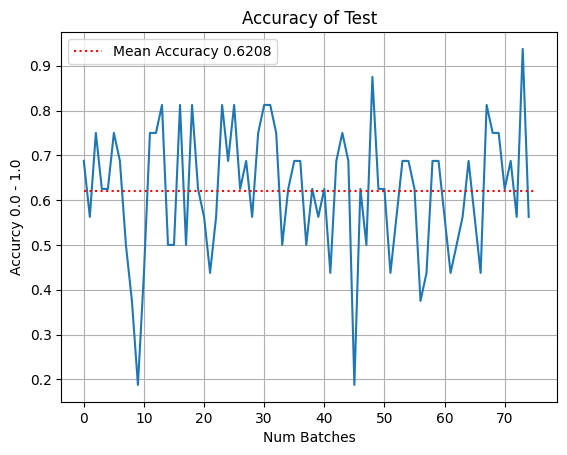

In [54]:
plot_test_metrics(test_acc_score)